# Avoiding catastrophic interference with Langevin dynamics in the vicinity of local minima

The posterior probability function is sampled with Langevin dynamics around local minima of several samples (anchors) retained from previous datasets. Predictor-corrector algorithm is **not** used for Brownian dynamics.

The method is tested on permutted MNIST data. 

In [1]:
import os
# Disable GPU in a case of kernel freezing
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras import utils
from keras import regularizers
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
#from scipy.misc import toimage
%matplotlib inline 
#import PIL.Image as pil
from progressbar import ProgressBar, Bar, Percentage  # pip install progressbar33
from keras import optimizers
from keras.callbacks import EarlyStopping
from scipy.special import expit
#import pickle

Using TensorFlow backend.


In [3]:
# Training parameters

num_epoch = 20
num_neur = 400 # number of neurons in hidden layers
num_class = 10
img_line = 784
#vspl = 0.2 # validation split rate
bsize = 32 # batch size
predictor_corrector = True # whether to use predictor-corrector for Brownian motion

# hyperparameters for samples generation
#min_delta = 0.0001 # early stop criterion
nb_retain = 5 # number of samples per class from previous datasets to retain
nb_samples = 1000 # number of samples to collect near each local minimum
demix = 10 # number of consequtive samples to skip to prevent mixing
llr = 0.1 # learning rate for Largevin sampling
ll2 = 0.01 # prior weights distribution
eps = np.finfo(float).eps # machine epsilon

Load and preprocess MNIST dataset

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
# Prepare data
X_train = X_train.reshape(60000, img_line)
X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.reshape(10000, img_line)
X_test = X_test.astype('float32')
X_test /= 255

Y_train = utils.to_categorical(y_train, 10)
Y_test = utils.to_categorical(y_test, 10)

# Construct a network for training on MNIST data
model = Sequential()
l2 = 1e-4 # L2 regularization
model.add(Dense(num_neur, input_dim=img_line, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_neur, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_class, activation="softmax",kernel_regularizer=regularizers.l2(l2)))

model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.001), metrics=["accuracy"])

## Training network  on data A

In [6]:
order_a = np.random.permutation(img_line)
tr_a = X_train[:,order_a] # training set A
ts_a = X_test[:,order_a] # test set A

score_a = np.zeros((num_epoch,2))
history = model.fit(tr_a, Y_train, batch_size=bsize, epochs=num_epoch, validation_data=(ts_a,Y_test), verbose=0)
score_a[:,0] = range(num_epoch)
score_a[:,1] = history.history['val_acc']

# plt.plot(score_a[:,0],score_a[:,1])
# plt.xlabel('Эпоха обучения')
# plt.ylabel('Аккуратность')
# plt.show()

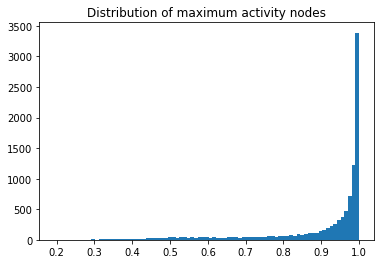

In [7]:
# plot the histogram of output activations
pred = model.predict(ts_a)
pred_max = np.amax(pred, axis=1) # take maximum value of every output vector
plt.hist(pred_max, bins='auto')  
plt.title("Distribution of maximum activity nodes")
plt.show()

## Generate samples corresponding to data A

Construct network for posterior sampling

In [8]:
# Freeze all the layers in the trained network
for layer in model.layers:
    layer.trainable = False
    
x_in = np.array([[1]]) # the only input for the new network
#early_stopping = EarlyStopping(monitor='loss', min_delta=min_delta)

# Construct neural net for samples generation 
model_dream = Sequential()
model_dream.add(Dense(784,input_dim=1,kernel_initializer="uniform",
                      kernel_regularizer=regularizers.l2(ll2),activation='sigmoid',use_bias=False))
model_dream.add(model)
sgd = optimizers.SGD(lr=llr)
model_dream.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=["accuracy"])

Pick random anchors from dataset A

In [9]:
anchors_xa = np.empty(shape=[0, img_line]) # reference points for sample collection
anchors_ya = np.empty(shape=[0, num_class])

# choose correctly classified samples (otherwise Brownian dynamics does not work)
y_out = model.predict(tr_a)
ind = (np.argmax(y_out, axis=1)==np.argmax(Y_train, axis=1))
x_corr = tr_a[ind,:]
y_corr = Y_train[ind,:]

for node in range(num_class): # pick random anchors for every output node
    ind = (y_corr[:,node]==1) # indices of samples of a particular class
    x_tmp = x_corr[ind,:]
    y_tmp = y_corr[ind,:]
    ind = np.random.permutation(x_tmp.shape[0]) # permute samples of the class
    x_tmp = x_tmp[ind,:]
    x_tmp = x_tmp[:nb_retain,:] # pick anchors
    y_tmp = y_tmp[:nb_retain,:]
    anchors_xa = np.vstack((anchors_xa, x_tmp)) # collect all the anchors 
    anchors_ya = np.vstack((anchors_ya, y_tmp))    

start collecting samples

In [10]:
dreams_a = np.empty(shape=[0, img_line]) # array to store samples
pbar = ProgressBar(widgets=['Creating dreams: ',Percentage(),Bar()], maxval=anchors_xa.shape[0]).start()
for ind in range(anchors_xa.shape[0]): # generate dreams for anchor
    dream = anchors_xa[ind:ind+1,:]
    y_out = anchors_ya[ind:ind+1,:]
    weights = np.log((dream+eps)/(1-dream+eps)) # convert pattern into weights
    model_dream.layers[0].set_weights([weights]) # set a point of local minimum 
    collected_samples = 0
    nb_steps = 0 # number of steps after last collected sample
    dreams1 = np.zeros((nb_samples,img_line)) # samples around particular anchor
    while collected_samples<nb_samples: 
        model_dream.fit(x_in,y_out,batch_size=1,epochs=1,verbose=0,shuffle=False) # one step of gradient descend
        weights = model_dream.layers[0].get_weights()[0] # input weights after gradient descend
        while True: # try random steps until suitable one
            xi = np.sqrt(2*llr)*np.random.normal(0,1,weights.shape) # Gaussian noise
            new_weights = weights+xi # gradient descend + Gaussian noise
            dream = expit(new_weights) # produced sample input
            y1 = model.predict(dream)
            if np.argmax(y1)==np.argmax(y_out): # if sample generate correct output activity
                if nb_steps==demix:
                    dreams1[collected_samples,:] = dream # keep sample if good activity
                    nb_steps = 0
                    collected_samples += 1
                nb_steps += 1
                model_dream.layers[0].set_weights([new_weights])
                break
    dreams_a = np.append(dreams_a, dreams1, axis=0) # collect samples for each restart
    pbar.update(ind+1)
pbar.finish()

Creating dreams: 100%|########################################################|


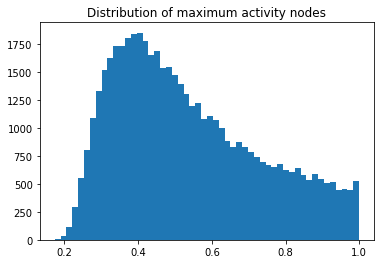

In [11]:
dreamY_a = model.predict(dreams_a)
# plot the histogram of output values
dreamY_max = np.amax(dreamY_a, axis=1) # take maximum value of every output vector
plt.hist(dreamY_max, bins='auto')  
plt.title("Distribution of maximum activity nodes")
plt.show()

## Training network on data B

Use data B together with dreams for training

100% |########################################################################|


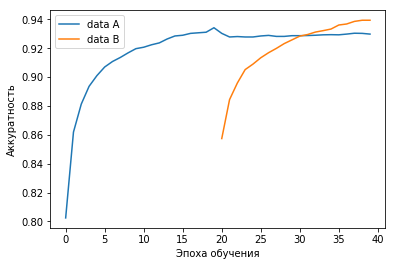

In [12]:
# Unfreeze all the layers before training
for layer in model.layers:
    layer.trainable = True
    
# construct B data
order_b = np.random.permutation(img_line)
#np.savetxt('RL_order_b.txt', order_b, fmt='%d') # save permutation order for data B
tr_b = X_train[:,order_b]
ts_b = X_test[:,order_b]

tr_ab = np.concatenate((tr_b, dreams_a), axis=0) # add pseudodata to the training data
Y_ab = np.concatenate((Y_train, dreamY_a), axis=0) # add pseudotargets to the targets
    
# permute training samples for proper validation set
order_all = np.random.permutation(tr_ab.shape[0])
tr_ab = tr_ab[order_all,:]
Y_ab = Y_ab[order_all,:]

score_ab = np.zeros((num_epoch,3))
pbar = ProgressBar(maxval=num_epoch).start()
for epoch in range(num_epoch):
    model.fit(tr_ab, Y_ab, batch_size=bsize, epochs=1, verbose=0)
    score1 = model.evaluate(ts_a, Y_test, verbose=0)
    score2 = model.evaluate(ts_b, Y_test, verbose=0)
    score_ab[epoch,:] = [epoch+num_epoch,score1[1],score2[1]]
    pbar.update(epoch+1)
pbar.finish()
# model.save_weights('RL_weights_ab.h5') # save weights for further use
# np.save('RL_score_ab', score_ab) # save the history of training

# plot the accuracy of training
plt.plot(np.hstack((score_a[:,0],score_ab[:,0])),np.hstack((score_a[:,1],score_ab[:,1])),label='data A')
plt.plot(score_ab[:,0],score_ab[:,2],label='data B')
plt.xlabel('Эпоха обучения')
plt.ylabel('Аккуратность')
plt.legend()
plt.show()

## Generate samples corresponding to datasets A and B

In [13]:
# Freeze all the layers in the trained network
for layer in model.layers:
    layer.trainable = False
    
x_in = np.array([[1]]) # the only input for the new network
#early_stopping = EarlyStopping(monitor='loss', min_delta=min_delta)

# Construct neural net for samples generation 
model_dream = Sequential()
model_dream.add(Dense(784,input_dim=1,kernel_initializer="uniform",
                      kernel_regularizer=regularizers.l2(ll2),activation='sigmoid',use_bias=False))
model_dream.add(model)
sgd = optimizers.SGD(lr=llr)
model_dream.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=["accuracy"])

Pick random anchers from dataset B

In [14]:
anchors_xb = np.empty(shape=[0, img_line]) # reference points for sample collection
anchors_yb = np.empty(shape=[0, num_class])

# choose correctly classified samples (otherwise Brownian dynamics does not work)
y_out = model.predict(tr_b)
ind = (np.argmax(y_out, axis=1)==np.argmax(Y_train, axis=1))
x_corr = tr_b[ind,:]
y_corr = Y_train[ind,:]

for node in range(num_class): # pick random anchors for every output node
    ind = (y_corr[:,node]==1) # indices of samples of a particular class
    x_tmp = x_corr[ind,:]
    y_tmp = y_corr[ind,:]
    ind = np.random.permutation(x_tmp.shape[0]) # permute samples of the class
    x_tmp = x_tmp[ind,:]
    x_tmp = x_tmp[:nb_retain,:] # pick anchors
    y_tmp = y_tmp[:nb_retain,:]
    anchors_xb = np.vstack((anchors_xb, x_tmp)) # collect all the anchors 
    anchors_yb = np.vstack((anchors_yb, y_tmp)) 

Join anchors of datasets A and B

In [15]:
anchors_xab = np.vstack((anchors_xa, anchors_xb)) 
anchors_yab = np.vstack((anchors_ya, anchors_yb)) 

Start collecting samples around anchors for datasets A and B

In [16]:
dreams_ab = np.empty(shape=[0, img_line]) # array to store samples
pbar = ProgressBar(widgets=['Creating dreams: ',Percentage(),Bar()], maxval=anchors_xab.shape[0]).start()
for ind in range(anchors_xab.shape[0]): # generate dreams for anchor
    dream = anchors_xab[ind:ind+1,:]
    y_out = anchors_yab[ind:ind+1,:]
    weights = np.log((dream+eps)/(1-dream+eps)) # convert pattern into weights
    model_dream.layers[0].set_weights([weights]) # set a point of local minimum 
    collected_samples = 0
    nb_steps = 0 # number of steps after last collected sample
    dreams1 = np.zeros((nb_samples,img_line)) # samples around particular anchor
    while collected_samples<nb_samples: 
        model_dream.fit(x_in,y_out,batch_size=1,epochs=1,verbose=0,shuffle=False) # one step of gradient descend
        weights = model_dream.layers[0].get_weights()[0] # input weights after gradient descend
        while True: # try random steps until suitable one
            xi = np.sqrt(2*llr)*np.random.normal(0,1,weights.shape) # Gaussian noise
            new_weights = weights+xi # gradient descend + Gaussian noise
            dream = expit(new_weights) # produced sample input
            y1 = model.predict(dream)
            if np.argmax(y1)==np.argmax(y_out): # if sample generate correct output activity
                if nb_steps==demix:
                    dreams1[collected_samples,:] = dream # keep sample if good activity
                    nb_steps = 0
                    collected_samples += 1
                nb_steps += 1
                model_dream.layers[0].set_weights([new_weights])
                break
    dreams_ab = np.append(dreams_ab, dreams1, axis=0) # collect samples for each restart
    pbar.update(ind+1)
pbar.finish()

Creating dreams: 100%|########################################################|


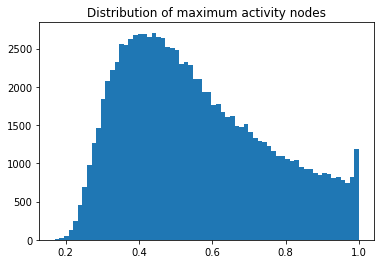

In [17]:
dreamsY_ab = model.predict(dreams_ab)
# plot the histogram of output values
dreamY_max = np.amax(dreamsY_ab, axis=1) # take maximum value of every output vector
plt.hist(dreamY_max, bins='auto')  
plt.title("Distribution of maximum activity nodes")
plt.show()

## Training network on data C

100% |########################################################################|


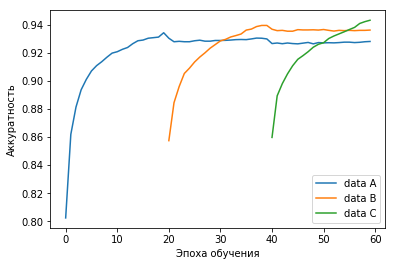

In [18]:
# Unfreeze all the layers before training
for layer in model.layers:
    layer.trainable = True

# create dataset C
order_c = np.random.permutation(img_line)
tr_c = X_train[:,order_c]
ts_c = X_test[:,order_c]

# add pseudodata to the training data
tr_abc = np.concatenate((tr_c, dreams_ab), axis=0) 
Y_abc = np.concatenate((Y_train, dreamsY_ab), axis=0)
# permute training samples for proper validation set
order_all = np.random.permutation(tr_abc.shape[0])
tr_abc = tr_abc[order_all,:]
Y_abc = Y_abc[order_all,:]

score_abc = np.zeros((num_epoch,4))
pbar = ProgressBar(maxval=num_epoch).start()
for epoch in range(num_epoch):
    model.fit(tr_abc, Y_abc, batch_size=bsize, epochs=1, verbose=0)
    score1 = model.evaluate(ts_a, Y_test, verbose=0)
    score2 = model.evaluate(ts_b, Y_test, verbose=0)
    score3 = model.evaluate(ts_c, Y_test, verbose=0)
    score_abc[epoch,:] = [epoch+num_epoch*2,score1[1],score2[1],score3[1]]
    pbar.update(epoch+1)
pbar.finish()

#plot training history
plt.plot(np.concatenate((score_a[:,0],score_ab[:,0],score_abc[:,0]),axis=0),
         np.concatenate((score_a[:,1],score_ab[:,1],score_abc[:,1]),axis=0),label='data A')
plt.plot(np.hstack((score_ab[:,0],score_abc[:,0])),np.hstack((score_ab[:,2],score_abc[:,2])),label='data B')
plt.plot(score_abc[:,0],score_abc[:,3],label='data C')
plt.xlabel('Эпоха обучения')
plt.ylabel('Аккуратность')
plt.legend()
plt.show()

In [19]:
np.savez('Restricted_Langevin_anchors9',score_a=score_a,score_ab=score_ab,score_abc=score_abc)